In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

In [2]:
df1 = pd.read_csv('data/LdP.csv')
df2 = pd.read_csv('data/LdP2.csv')

In [3]:
df1.columns = df2.columns  

In [4]:
df = pd.concat([df1, df2], ignore_index=True)

In [5]:
df = df.rename(columns={
    "Carimbo de data/hora": "Carimbo_de_data_hora",
    "Temperatura": "Temperatura", 
    "Umidade do Ar": "Umidade_do_Ar",
    "Umidade do Solo": "Umidade_do_Solo",
})

In [6]:
df["Carimbo_de_data_hora"] = pd.to_datetime(
    df["Carimbo_de_data_hora"],
    format="%d/%m/%Y %H:%M:%S"  
)

In [7]:
first_time = df['Carimbo_de_data_hora'].iloc[0]

df['Minutos_Decorridos'] = (df['Carimbo_de_data_hora'] - first_time).dt.total_seconds() / 60

df['Minutos_Decorridos'] = df['Minutos_Decorridos'].round(2)



In [8]:
data_busca = '01/07/2025 21:47:51'
data_busca_dt = pd.to_datetime(data_busca, format='%d/%m/%Y %H:%M:%S')

# Encontrar e imprimir a linha correspondente
linha = df[df['Carimbo_de_data_hora'] == data_busca_dt]
print(linha)

    Carimbo_de_data_hora  Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
500  2025-07-01 21:47:51         21.6           91.1             99.6   

     Minutos_Decorridos  
500            19957.83  


In [9]:
periodos_secagem = [
    (0.0,  5041.85),       
    (5071.85, 7804.25),   
    (7834.27, 14044.57),  
    (14074.58, 19927.83),  
    (19957.83, df['Minutos_Decorridos'].max()) 
]

In [10]:
df_sec = pd.DataFrame()

In [11]:

id_atual = 0
for inicio, fim in periodos_secagem:
    segmento = df[(df['Minutos_Decorridos'] >= inicio) & (df['Minutos_Decorridos'] <= fim)].copy()
    segmento['ID_Ciclo'] = id_atual 
    df_sec = pd.concat([df_sec, segmento], ignore_index=False)
    id_atual += 1

print(f"\nNúmero de linhas no DataFrame de secagem para modelagem: {df_sec.shape[0]}")
print(f"Número de ciclos identificados: {df_sec['ID_Ciclo'].nunique()}")
print(f"Primeiras 5 linhas do DataFrame de secagem:\n{df_sec.head()}")
print(f"Últimas 5 linhas do DataFrame de secagem:\n{df_sec.tail()}")


Número de linhas no DataFrame de secagem para modelagem: 921
Número de ciclos identificados: 5
Primeiras 5 linhas do DataFrame de secagem:
  Carimbo_de_data_hora  Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
0  2025-06-18 01:10:01         22.0           83.6             86.1   
1  2025-06-18 01:40:02         22.0           83.7             87.0   
2  2025-06-18 02:10:02         20.6           89.9             88.4   
3  2025-06-18 02:40:03         20.3           90.8             87.8   
4  2025-06-18 03:10:04         20.3           90.4             88.4   

   Minutos_Decorridos  ID_Ciclo  
0                0.00         0  
1               30.02         0  
2               60.02         0  
3               90.03         0  
4              120.05         0  
Últimas 5 linhas do DataFrame de secagem:
    Carimbo_de_data_hora  Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
916  2025-07-10 18:36:23         21.9           72.9             84.2   
917  2025-07-10 19:06:24         21.8    

In [12]:
df_sec['Minutos_Decorridos_No_Ciclo'] = df_sec.groupby('ID_Ciclo')['Minutos_Decorridos'].transform(lambda x: x - x.min())
df_sec['Minutos_Decorridos_No_Ciclo'] = df_sec['Minutos_Decorridos_No_Ciclo'].round(2)

print(f"\nDataFrame de secagem final: {df_sec.shape[0]} linhas")
print(f"Primeiras 5 linhas com Minutos_Decorridos_No_Ciclo:\n{df_sec[['Minutos_Decorridos', 'Minutos_Decorridos_No_Ciclo', 'Umidade_do_Solo', 'ID_Ciclo']].head()}")


DataFrame de secagem final: 921 linhas
Primeiras 5 linhas com Minutos_Decorridos_No_Ciclo:
   Minutos_Decorridos  Minutos_Decorridos_No_Ciclo  Umidade_do_Solo  ID_Ciclo
0                0.00                         0.00             86.1         0
1               30.02                        30.02             87.0         0
2               60.02                        60.02             88.4         0
3               90.03                        90.03             87.8         0
4              120.05                       120.05             88.4         0


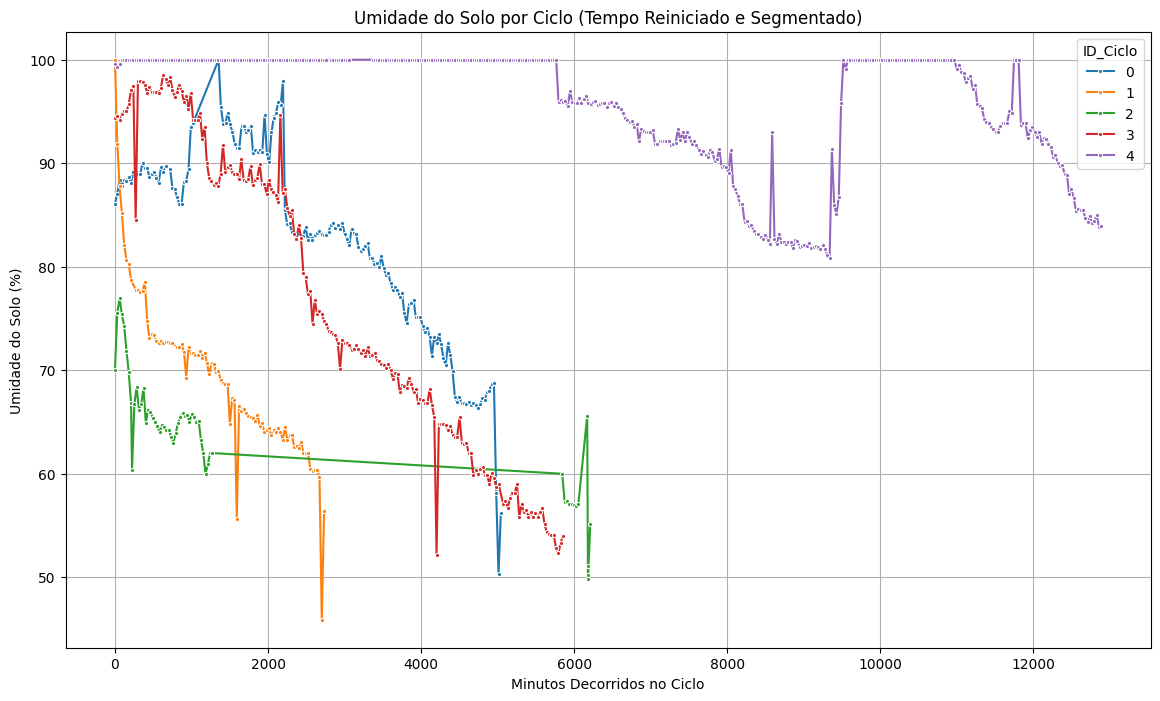

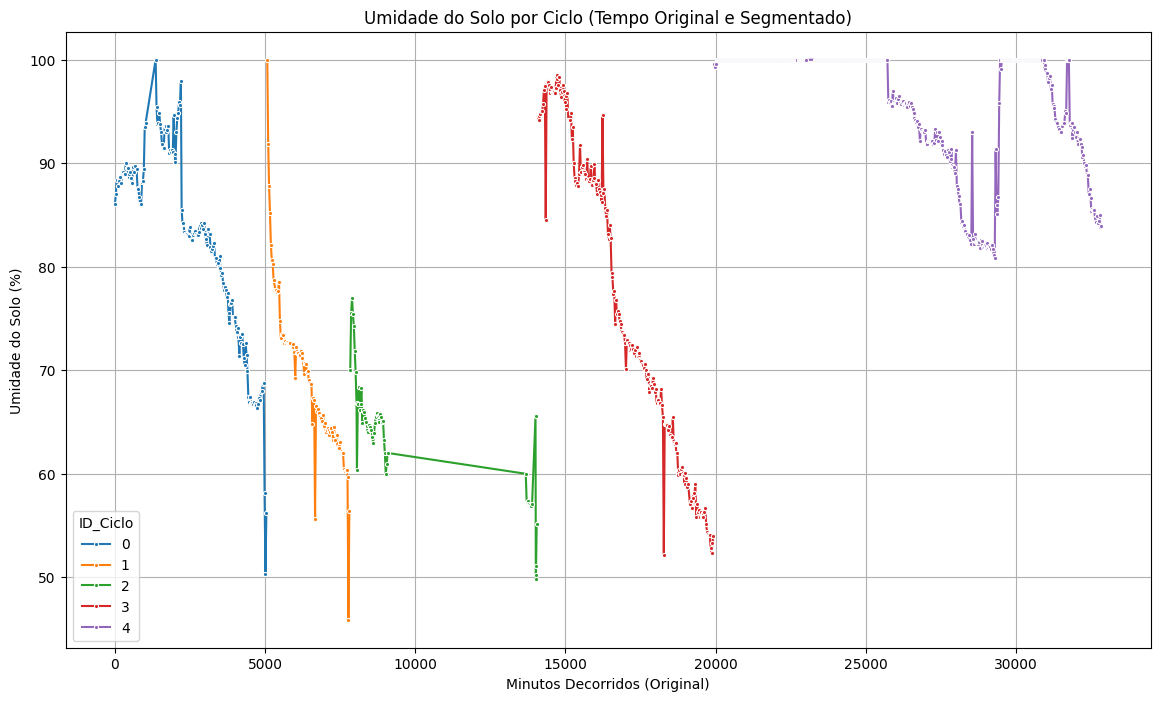

In [13]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_sec, x='Minutos_Decorridos_No_Ciclo', y='Umidade_do_Solo', hue='ID_Ciclo', marker='.', palette='tab10', legend='full')
plt.title('Umidade do Solo por Ciclo (Tempo Reiniciado e Segmentado)')
plt.xlabel('Minutos Decorridos no Ciclo')
plt.ylabel('Umidade do Solo (%)')
plt.grid(True)
plt.show()


plt.figure(figsize=(14, 8))
sns.lineplot(data=df_sec, x='Minutos_Decorridos', y='Umidade_do_Solo', hue='ID_Ciclo', marker='.', palette='tab10', legend='full')
plt.title('Umidade do Solo por Ciclo (Tempo Original e Segmentado)')
plt.xlabel('Minutos Decorridos (Original)')
plt.ylabel('Umidade do Solo (%)')
plt.grid(True)
plt.show()

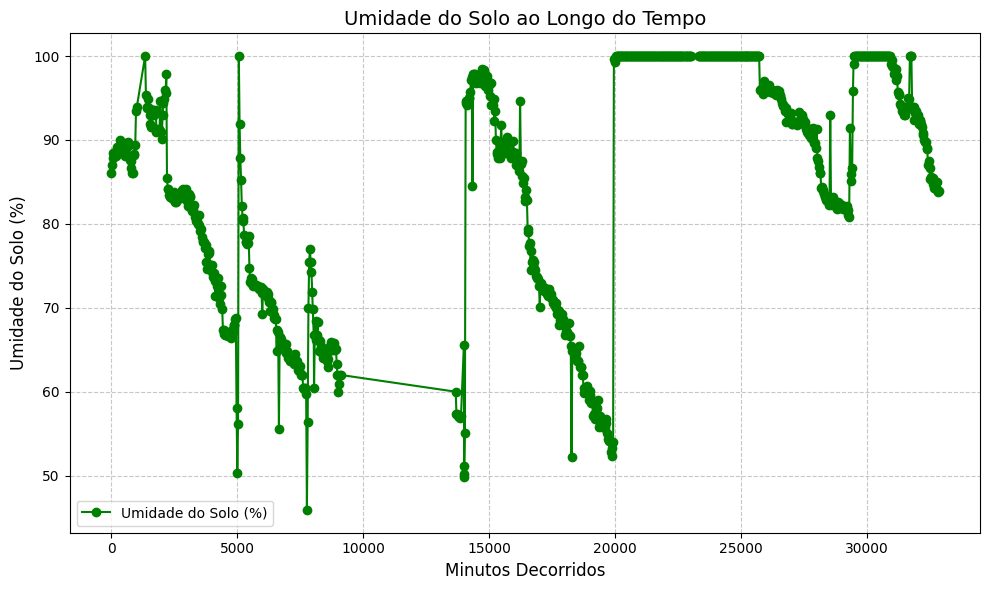

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(
    df['Minutos_Decorridos'],
    df['Umidade_do_Solo'],
    marker='o',  
    linestyle='-',  
    color='green',
    label='Umidade do Solo (%)'
)


plt.title("Umidade do Solo ao Longo do Tempo", fontsize=14)
plt.xlabel("Minutos Decorridos", fontsize=12)
plt.ylabel("Umidade do Solo (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
print(df.dtypes)

Carimbo_de_data_hora    datetime64[ns]
Temperatura                    float64
Umidade_do_Ar                  float64
Umidade_do_Solo                float64
Minutos_Decorridos             float64
dtype: object


In [16]:
print(df_sec.head())

  Carimbo_de_data_hora  Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
0  2025-06-18 01:10:01         22.0           83.6             86.1   
1  2025-06-18 01:40:02         22.0           83.7             87.0   
2  2025-06-18 02:10:02         20.6           89.9             88.4   
3  2025-06-18 02:40:03         20.3           90.8             87.8   
4  2025-06-18 03:10:04         20.3           90.4             88.4   

   Minutos_Decorridos  ID_Ciclo  Minutos_Decorridos_No_Ciclo  
0                0.00         0                         0.00  
1               30.02         0                        30.02  
2               60.02         0                        60.02  
3               90.03         0                        90.03  
4              120.05         0                       120.05  


In [17]:
df_num = df.select_dtypes(include=['float64', 'int64'])

In [18]:
colunas_para_correlacao_ciclo = [
    'Temperatura',
    'Umidade_do_Ar',
    'Umidade_do_Solo',
    'Minutos_Decorridos_No_Ciclo' 
]

In [19]:
unique_cycle_ids = df_sec['ID_Ciclo'].unique()
unique_cycle_ids.sort()


Análise de Correlação Detalhada por Ciclo de Secagem
CICLO 0 - Correlação de Pearson
                             Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura                        1.000         -0.929           -0.225   
Umidade_do_Ar                     -0.929          1.000            0.317   
Umidade_do_Solo                   -0.225          0.317            1.000   
Minutos_Decorridos_No_Ciclo        0.282         -0.336           -0.850   

                             Minutos_Decorridos_No_Ciclo  
Temperatura                                        0.282  
Umidade_do_Ar                                     -0.336  
Umidade_do_Solo                                   -0.850  
Minutos_Decorridos_No_Ciclo                        1.000  


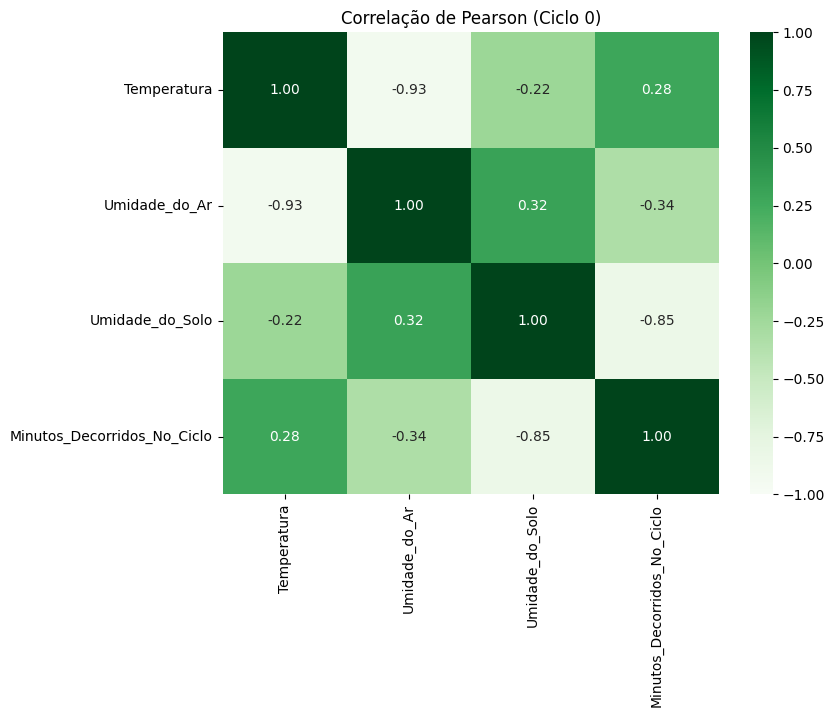

CICLO 0 - Correlação de Spearman
                             Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura                        1.000         -0.931           -0.218   
Umidade_do_Ar                     -0.931          1.000            0.283   
Umidade_do_Solo                   -0.218          0.283            1.000   
Minutos_Decorridos_No_Ciclo        0.289         -0.343           -0.879   

                             Minutos_Decorridos_No_Ciclo  
Temperatura                                        0.289  
Umidade_do_Ar                                     -0.343  
Umidade_do_Solo                                   -0.879  
Minutos_Decorridos_No_Ciclo                        1.000  


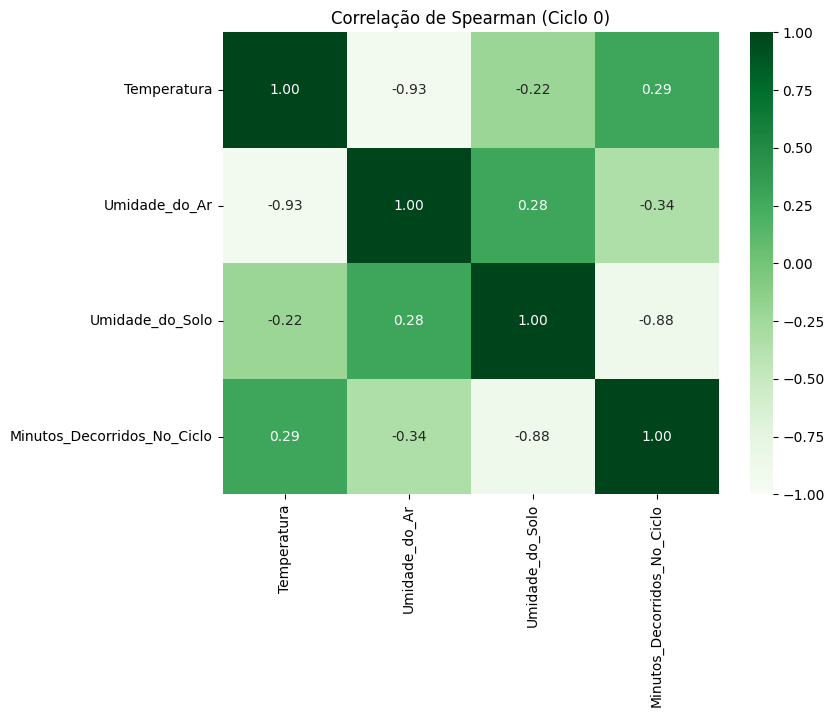

CICLO 0 - Correlação de Kendall (Tau)
                             Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura                        1.000         -0.780           -0.127   
Umidade_do_Ar                     -0.780          1.000            0.177   
Umidade_do_Solo                   -0.127          0.177            1.000   
Minutos_Decorridos_No_Ciclo        0.165         -0.204           -0.706   

                             Minutos_Decorridos_No_Ciclo  
Temperatura                                        0.165  
Umidade_do_Ar                                     -0.204  
Umidade_do_Solo                                   -0.706  
Minutos_Decorridos_No_Ciclo                        1.000  


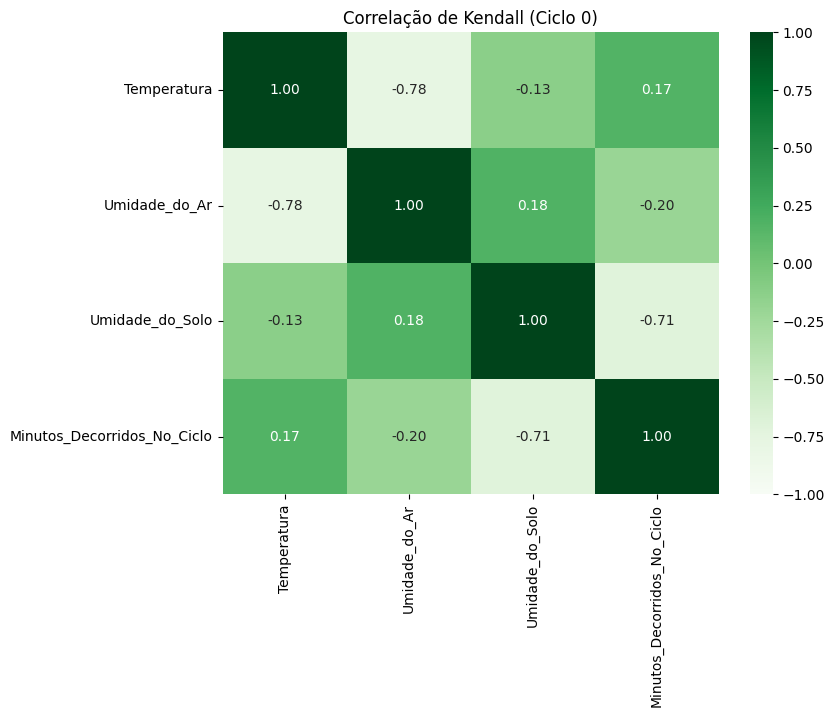

CICLO 1 - Correlação de Pearson
                             Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura                        1.000         -0.866            0.572   
Umidade_do_Ar                     -0.866          1.000           -0.590   
Umidade_do_Solo                    0.572         -0.590            1.000   
Minutos_Decorridos_No_Ciclo       -0.532          0.661           -0.894   

                             Minutos_Decorridos_No_Ciclo  
Temperatura                                       -0.532  
Umidade_do_Ar                                      0.661  
Umidade_do_Solo                                   -0.894  
Minutos_Decorridos_No_Ciclo                        1.000  


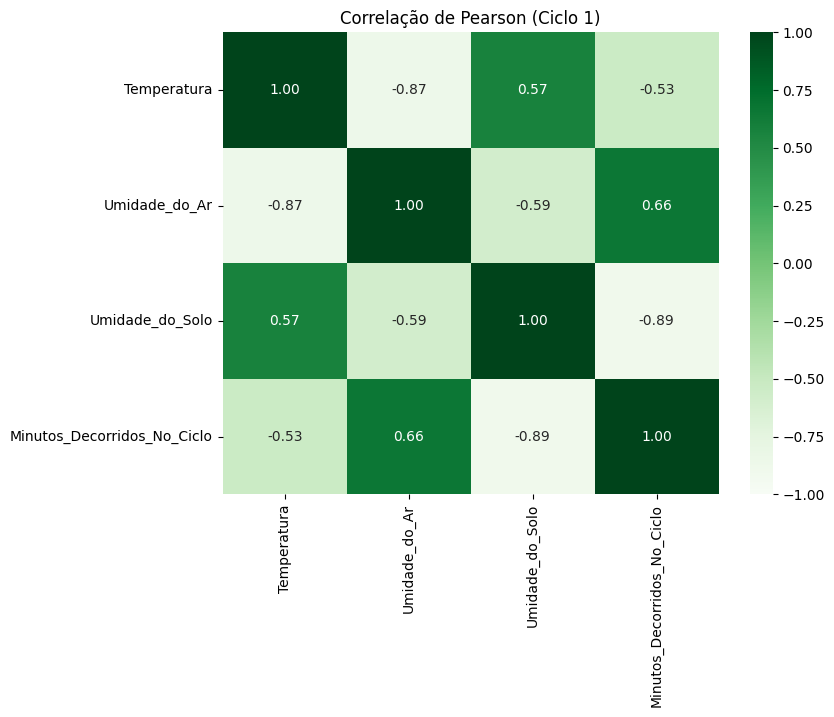

CICLO 1 - Correlação de Spearman
                             Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura                        1.000         -0.918            0.475   
Umidade_do_Ar                     -0.918          1.000           -0.586   
Umidade_do_Solo                    0.475         -0.586            1.000   
Minutos_Decorridos_No_Ciclo       -0.495          0.595           -0.982   

                             Minutos_Decorridos_No_Ciclo  
Temperatura                                       -0.495  
Umidade_do_Ar                                      0.595  
Umidade_do_Solo                                   -0.982  
Minutos_Decorridos_No_Ciclo                        1.000  


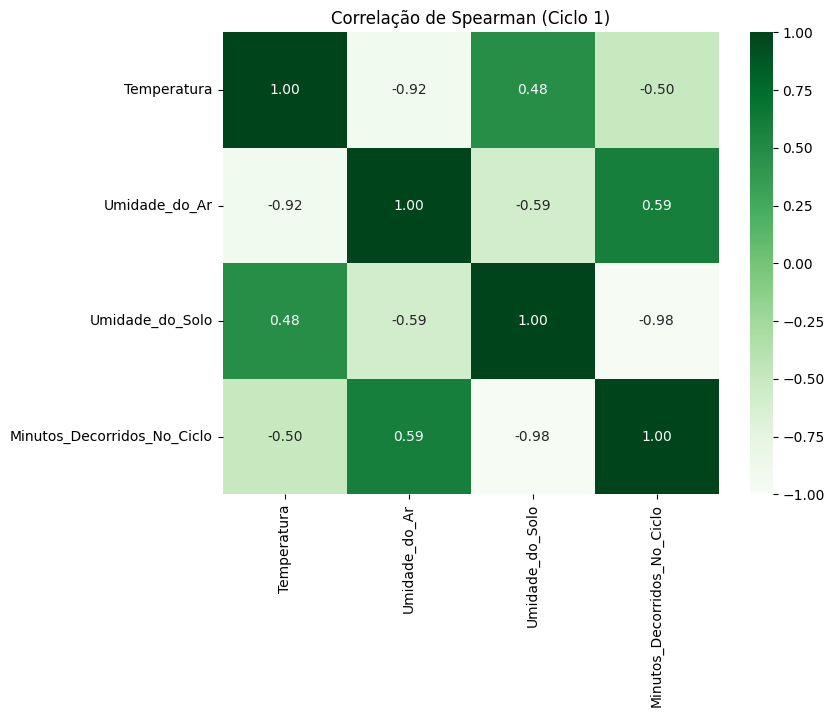

CICLO 1 - Correlação de Kendall (Tau)
                             Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura                        1.000         -0.756            0.393   
Umidade_do_Ar                     -0.756          1.000           -0.427   
Umidade_do_Solo                    0.393         -0.427            1.000   
Minutos_Decorridos_No_Ciclo       -0.428          0.442           -0.931   

                             Minutos_Decorridos_No_Ciclo  
Temperatura                                       -0.428  
Umidade_do_Ar                                      0.442  
Umidade_do_Solo                                   -0.931  
Minutos_Decorridos_No_Ciclo                        1.000  


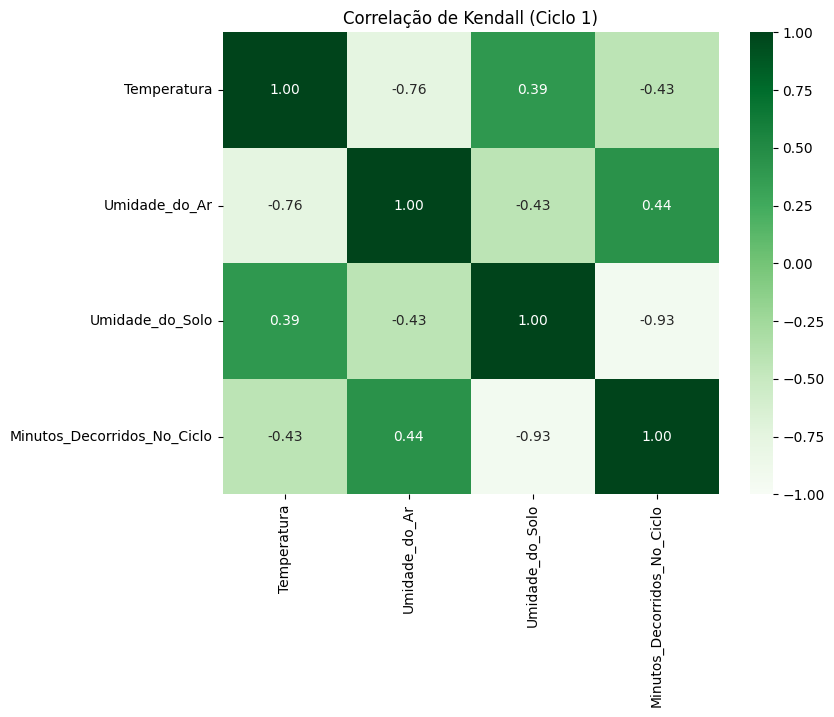

CICLO 2 - Correlação de Pearson
                             Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura                        1.000         -0.932            0.706   
Umidade_do_Ar                     -0.932          1.000           -0.683   
Umidade_do_Solo                    0.706         -0.683            1.000   
Minutos_Decorridos_No_Ciclo       -0.673          0.589           -0.785   

                             Minutos_Decorridos_No_Ciclo  
Temperatura                                       -0.673  
Umidade_do_Ar                                      0.589  
Umidade_do_Solo                                   -0.785  
Minutos_Decorridos_No_Ciclo                        1.000  


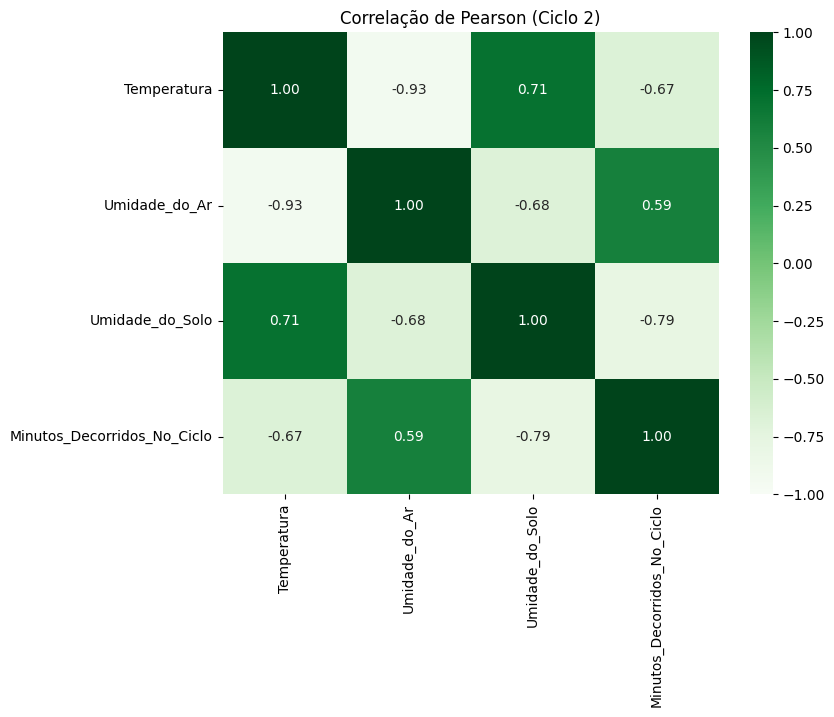

CICLO 2 - Correlação de Spearman
                             Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura                        1.000         -0.910            0.805   
Umidade_do_Ar                     -0.910          1.000           -0.708   
Umidade_do_Solo                    0.805         -0.708            1.000   
Minutos_Decorridos_No_Ciclo       -0.969          0.902           -0.828   

                             Minutos_Decorridos_No_Ciclo  
Temperatura                                       -0.969  
Umidade_do_Ar                                      0.902  
Umidade_do_Solo                                   -0.828  
Minutos_Decorridos_No_Ciclo                        1.000  


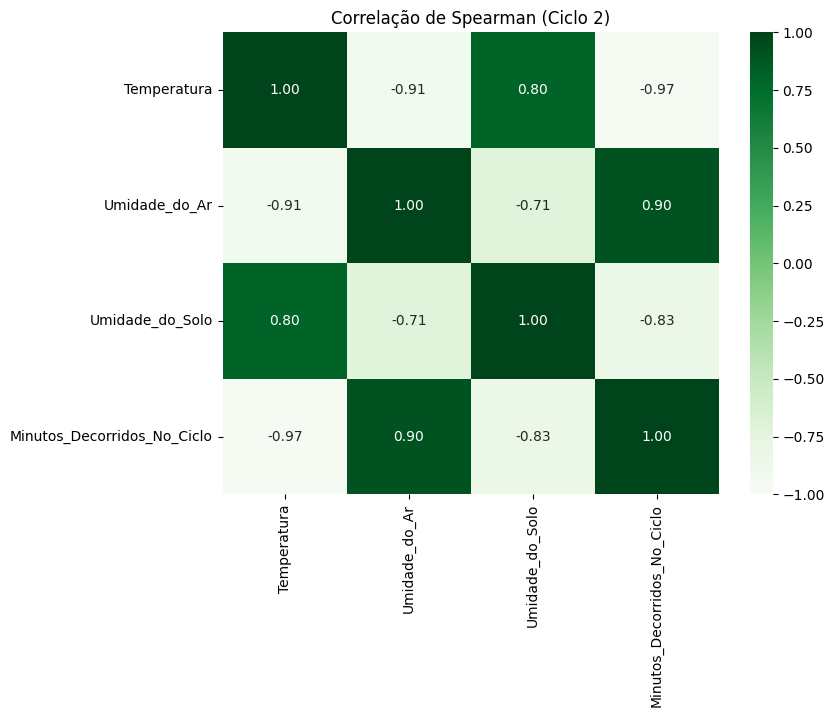

CICLO 2 - Correlação de Kendall (Tau)
                             Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura                        1.000         -0.771            0.648   
Umidade_do_Ar                     -0.771          1.000           -0.543   
Umidade_do_Solo                    0.648         -0.543            1.000   
Minutos_Decorridos_No_Ciclo       -0.852          0.718           -0.699   

                             Minutos_Decorridos_No_Ciclo  
Temperatura                                       -0.852  
Umidade_do_Ar                                      0.718  
Umidade_do_Solo                                   -0.699  
Minutos_Decorridos_No_Ciclo                        1.000  


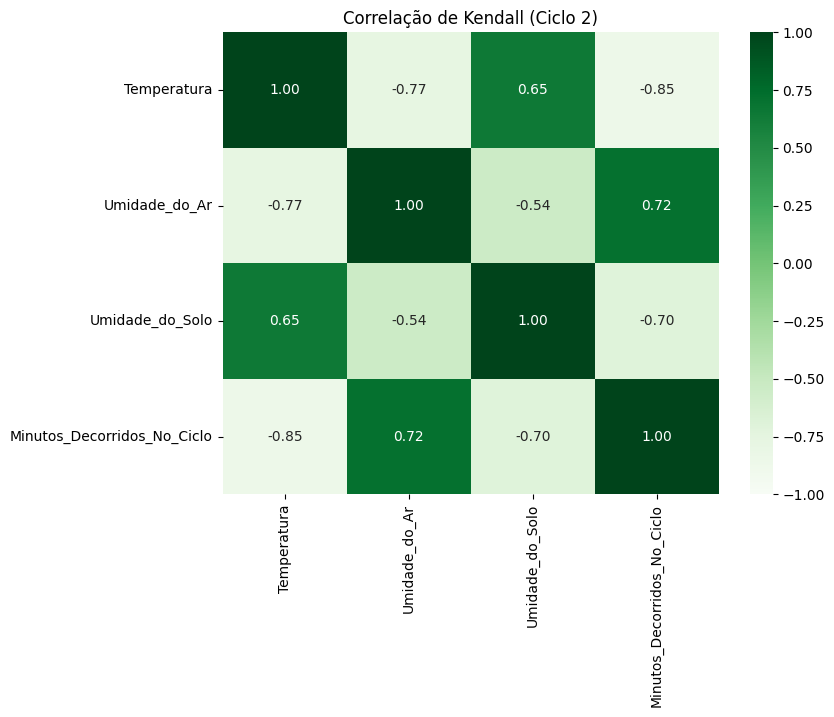

CICLO 3 - Correlação de Pearson
                             Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura                        1.000         -0.877           -0.151   
Umidade_do_Ar                     -0.877          1.000            0.188   
Umidade_do_Solo                   -0.151          0.188            1.000   
Minutos_Decorridos_No_Ciclo        0.089         -0.142           -0.981   

                             Minutos_Decorridos_No_Ciclo  
Temperatura                                        0.089  
Umidade_do_Ar                                     -0.142  
Umidade_do_Solo                                   -0.981  
Minutos_Decorridos_No_Ciclo                        1.000  


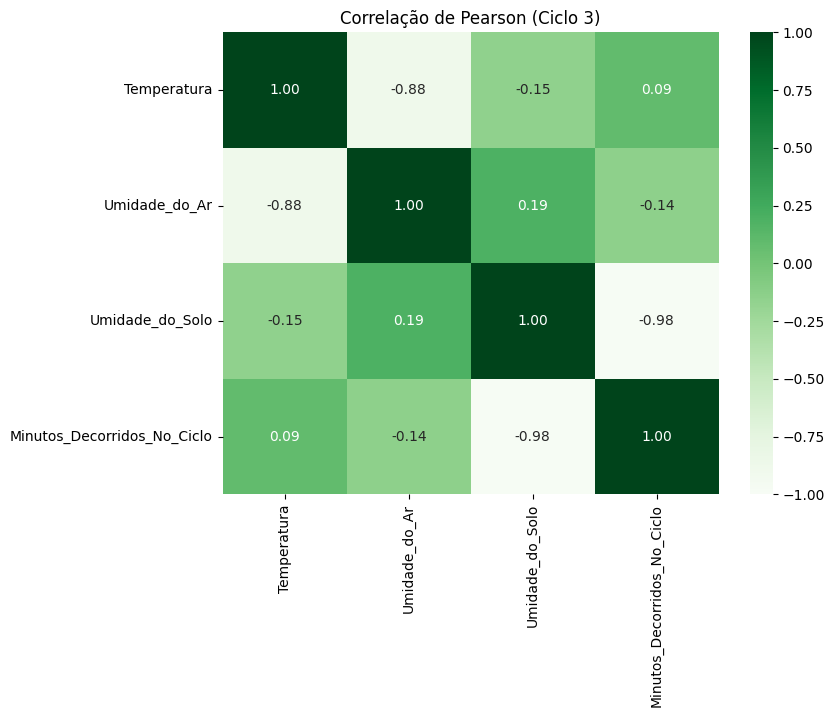

CICLO 3 - Correlação de Spearman
                             Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura                        1.000         -0.790           -0.188   
Umidade_do_Ar                     -0.790          1.000            0.278   
Umidade_do_Solo                   -0.188          0.278            1.000   
Minutos_Decorridos_No_Ciclo        0.162         -0.267           -0.982   

                             Minutos_Decorridos_No_Ciclo  
Temperatura                                        0.162  
Umidade_do_Ar                                     -0.267  
Umidade_do_Solo                                   -0.982  
Minutos_Decorridos_No_Ciclo                        1.000  


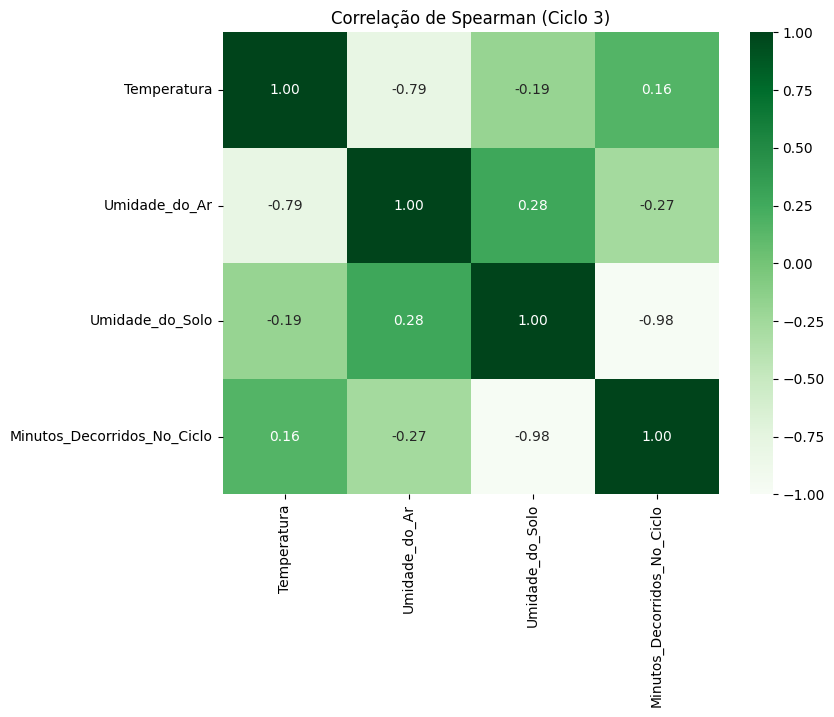

CICLO 3 - Correlação de Kendall (Tau)
                             Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura                        1.000         -0.617           -0.086   
Umidade_do_Ar                     -0.617          1.000            0.150   
Umidade_do_Solo                   -0.086          0.150            1.000   
Minutos_Decorridos_No_Ciclo        0.049         -0.128           -0.915   

                             Minutos_Decorridos_No_Ciclo  
Temperatura                                        0.049  
Umidade_do_Ar                                     -0.128  
Umidade_do_Solo                                   -0.915  
Minutos_Decorridos_No_Ciclo                        1.000  


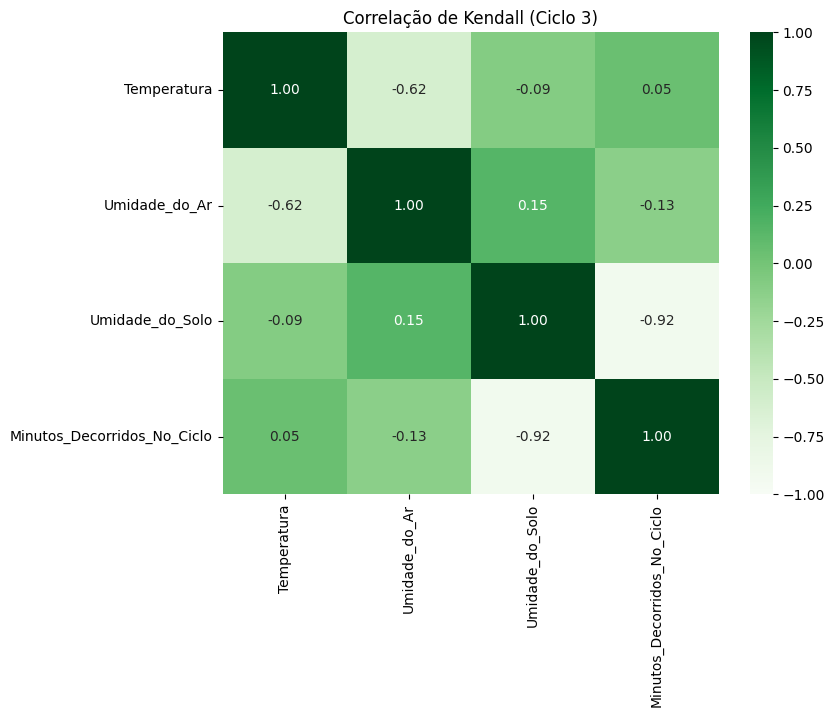

CICLO 4 - Correlação de Pearson
                             Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura                        1.000         -0.705           -0.081   
Umidade_do_Ar                     -0.705          1.000            0.163   
Umidade_do_Solo                   -0.081          0.163            1.000   
Minutos_Decorridos_No_Ciclo        0.259         -0.387           -0.536   

                             Minutos_Decorridos_No_Ciclo  
Temperatura                                        0.259  
Umidade_do_Ar                                     -0.387  
Umidade_do_Solo                                   -0.536  
Minutos_Decorridos_No_Ciclo                        1.000  


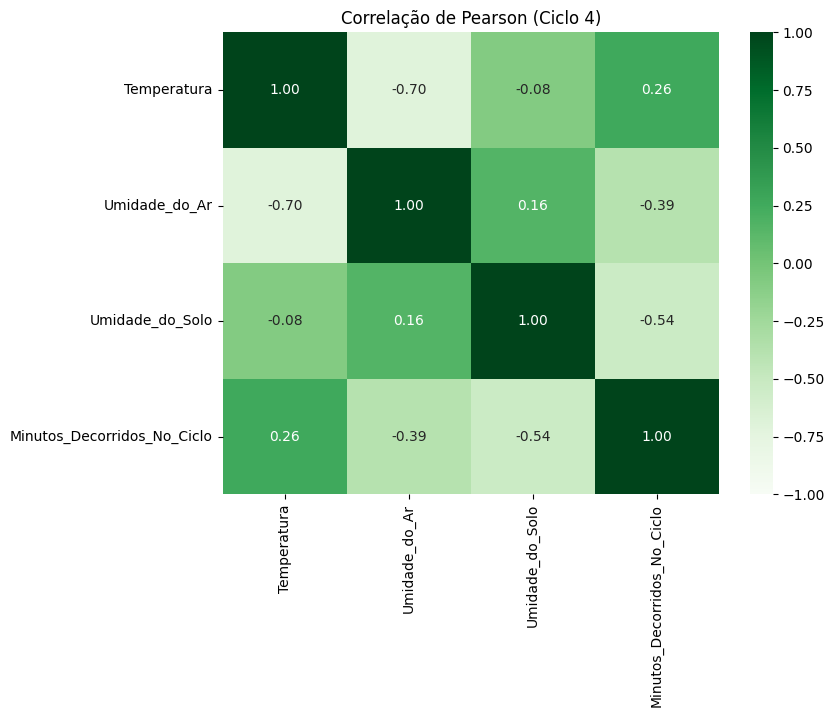

CICLO 4 - Correlação de Spearman
                             Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura                        1.000         -0.668           -0.113   
Umidade_do_Ar                     -0.668          1.000            0.239   
Umidade_do_Solo                   -0.113          0.239            1.000   
Minutos_Decorridos_No_Ciclo        0.247         -0.417           -0.591   

                             Minutos_Decorridos_No_Ciclo  
Temperatura                                        0.247  
Umidade_do_Ar                                     -0.417  
Umidade_do_Solo                                   -0.591  
Minutos_Decorridos_No_Ciclo                        1.000  


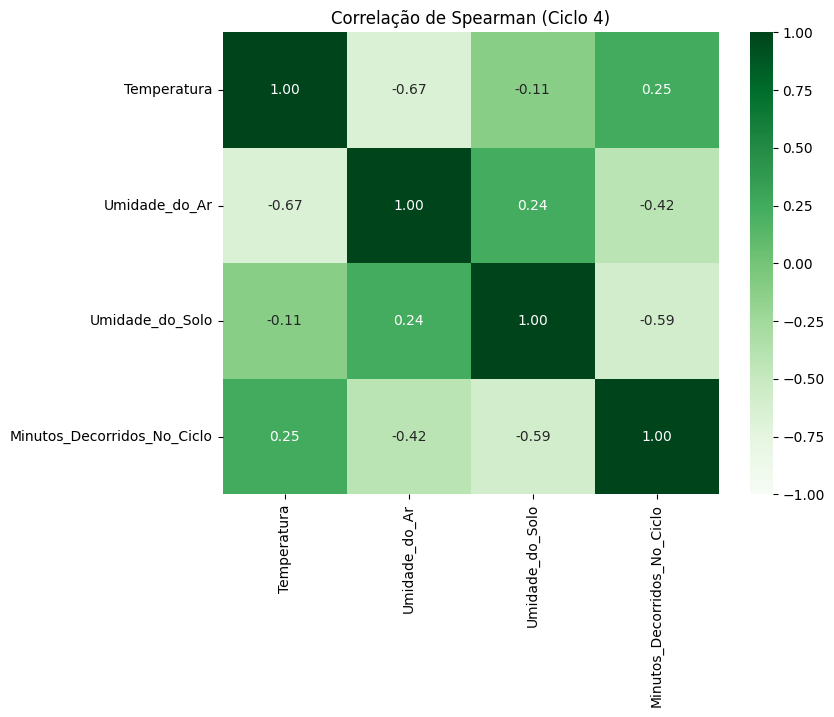

CICLO 4 - Correlação de Kendall (Tau)
                             Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura                        1.000         -0.493           -0.085   
Umidade_do_Ar                     -0.493          1.000            0.175   
Umidade_do_Solo                   -0.085          0.175            1.000   
Minutos_Decorridos_No_Ciclo        0.140         -0.274           -0.493   

                             Minutos_Decorridos_No_Ciclo  
Temperatura                                        0.140  
Umidade_do_Ar                                     -0.274  
Umidade_do_Solo                                   -0.493  
Minutos_Decorridos_No_Ciclo                        1.000  


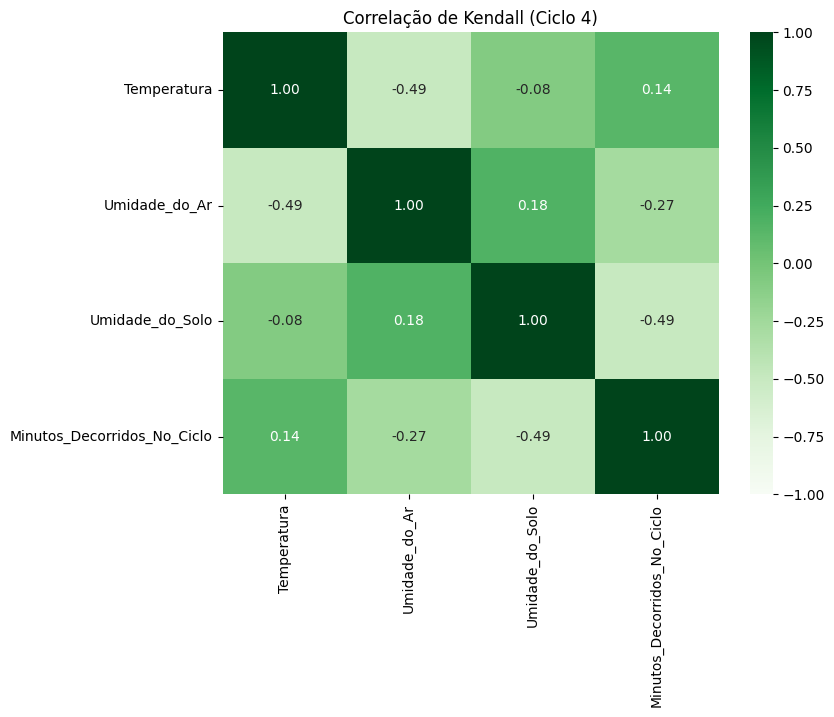

In [20]:
print("\nAnálise de Correlação Detalhada por Ciclo de Secagem")

for cycle_id in unique_cycle_ids:
    
    cycle_df = df_sec[df_sec['ID_Ciclo'] == cycle_id].copy()

   
    if len(cycle_df) < 2:
        print(f"\nAviso: Ciclo {cycle_id} tem apenas {len(cycle_df)} ponto(s). Insuficiente para correlação.")
        continue

    cycle_df_num = cycle_df[colunas_para_correlacao_ciclo]

    # correlação de Pearson 
    pearson_corr = cycle_df_num.corr(method='pearson')
    print(f"CICLO {cycle_id} - Correlação de Pearson")
    print(pearson_corr.round(3))
    plt.figure(figsize=(8, 6))
    sns.heatmap(pearson_corr, annot=True, cmap='Greens', vmin=-1, vmax=1, fmt=".2f")
    plt.title(f"Correlação de Pearson (Ciclo {cycle_id})")
    plt.show()

    # correlação de spearman
    spearman_corr = cycle_df_num.corr(method='spearman')
    print(f"CICLO {cycle_id} - Correlação de Spearman")
    print(spearman_corr.round(3))
    plt.figure(figsize=(8, 6))
    sns.heatmap(spearman_corr, annot=True, cmap='Greens', vmin=-1, vmax=1, fmt=".2f")
    plt.title(f"Correlação de Spearman (Ciclo {cycle_id})")
    plt.show()

    # correlação de Kendall 
    if len(cycle_df) >= 4: 
        kendall_corr = cycle_df_num.corr(method='kendall')
        print(f"CICLO {cycle_id} - Correlação de Kendall (Tau)")
        print(kendall_corr.round(3))
        plt.figure(figsize=(8, 6))
        sns.heatmap(kendall_corr, annot=True, cmap='Greens', vmin=-1, vmax=1, fmt=".2f")
        plt.title(f"Correlação de Kendall (Ciclo {cycle_id})")
        plt.show()
    else:
        print(f"\nAviso: Ciclo {cycle_id} tem apenas {len(cycle_df)} ponto(s). Insuficiente para Correlação de Kendall robusta.")


In [21]:
corr_pear_matrix = df_num.corr()
print("Correlação de Pearson (Todos os Ciclos) \n")
print(corr_pear_matrix)

Correlação de Pearson (Todos os Ciclos) 

                    Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura            1.000000      -0.750234        -0.623307   
Umidade_do_Ar         -0.750234       1.000000         0.341576   
Umidade_do_Solo       -0.623307       0.341576         1.000000   
Minutos_Decorridos    -0.591950       0.319584         0.464573   

                    Minutos_Decorridos  
Temperatura                  -0.591950  
Umidade_do_Ar                 0.319584  
Umidade_do_Solo               0.464573  
Minutos_Decorridos            1.000000  


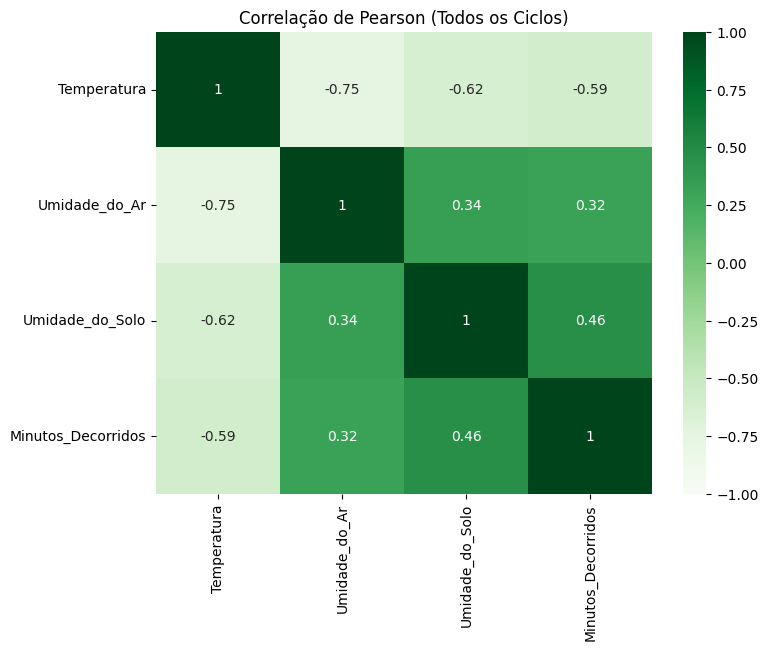

In [22]:
plt.figure(figsize = (8, 6))
sns.heatmap(corr_pear_matrix, annot=True, cmap='Greens', vmin=-1, vmax=1)
plt.title("Correlação de Pearson (Todos os Ciclos)")
plt.show()


In [23]:
corr_spear_matrix = df_num.corr(method='spearman')
print("Correlação de Sperman (Todos os Ciclos) \n")
print(corr_spear_matrix)

Correlação de Sperman (Todos os Ciclos) 

                    Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura            1.000000      -0.705127        -0.666321   
Umidade_do_Ar         -0.705127       1.000000         0.397948   
Umidade_do_Solo       -0.666321       0.397948         1.000000   
Minutos_Decorridos    -0.614968       0.261584         0.482073   

                    Minutos_Decorridos  
Temperatura                  -0.614968  
Umidade_do_Ar                 0.261584  
Umidade_do_Solo               0.482073  
Minutos_Decorridos            1.000000  


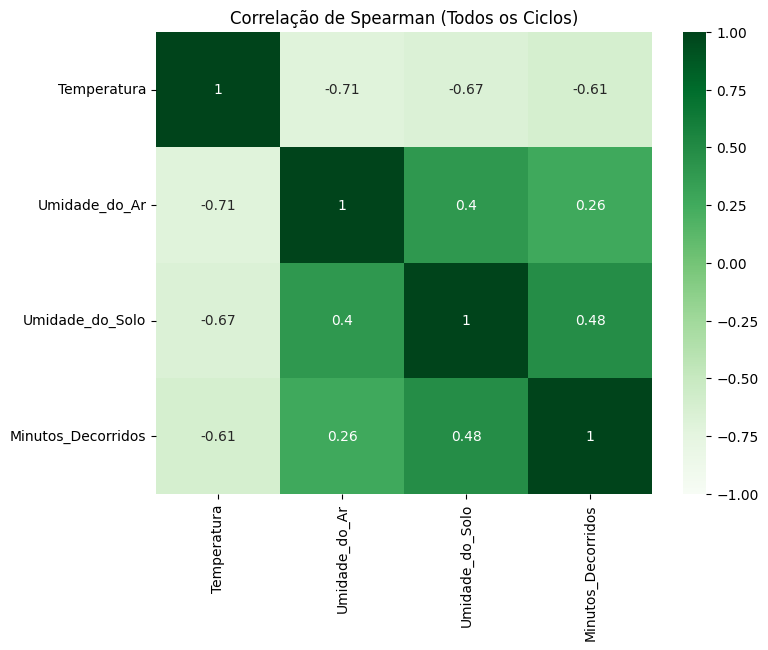

In [24]:
plt.figure(figsize = (8, 6))
sns.heatmap(corr_spear_matrix, annot=True, cmap='Greens', vmin=-1, vmax=1)
plt.title("Correlação de Spearman (Todos os Ciclos)")
plt.show()


In [25]:
corr_ken_matrix = df_num.corr(method='kendall')
print("Correlação de Kendall (Todos os Ciclos) \n")
print(corr_ken_matrix)

Correlação de Kendall (Todos os Ciclos) 

                    Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
Temperatura            1.000000      -0.524823        -0.462013   
Umidade_do_Ar         -0.524823       1.000000         0.268965   
Umidade_do_Solo       -0.462013       0.268965         1.000000   
Minutos_Decorridos    -0.405379       0.180043         0.229869   

                    Minutos_Decorridos  
Temperatura                  -0.405379  
Umidade_do_Ar                 0.180043  
Umidade_do_Solo               0.229869  
Minutos_Decorridos            1.000000  


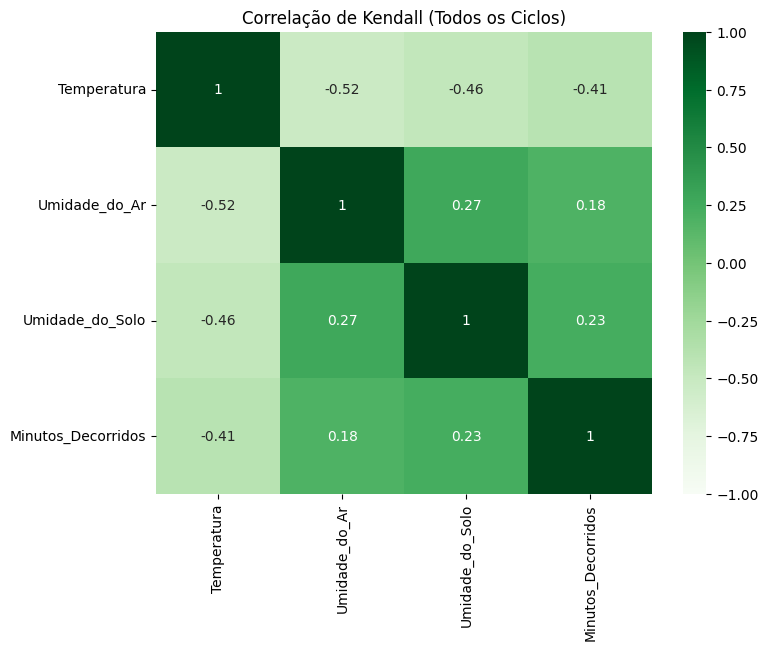

In [26]:
plt.figure(figsize = (8, 6))
sns.heatmap(corr_ken_matrix, annot=True, cmap='Greens', vmin=-1, vmax=1)
plt.title("Correlação de Kendall (Todos os Ciclos)")
plt.show()


In [27]:
file_name = "dados_finais.csv"
folder_path = "data"  

file_path = os.path.join(folder_path, file_name)


if not os.path.exists(folder_path):
    os.makedirs(folder_path)

if not os.path.exists(file_path):
    df_sec.to_csv(file_path, index=False, encoding='utf-8-sig')
    print(f"Arquivo salvo em: {os.path.abspath(file_path)}")
else:
    print(f"AVISO: O arquivo '{file_path}' já existe. Nada foi salvo.")





AVISO: O arquivo 'data\dados_finais.csv' já existe. Nada foi salvo.
